# Step 1: Collect the Data


[*********************100%***********************]  1 of 1 completed


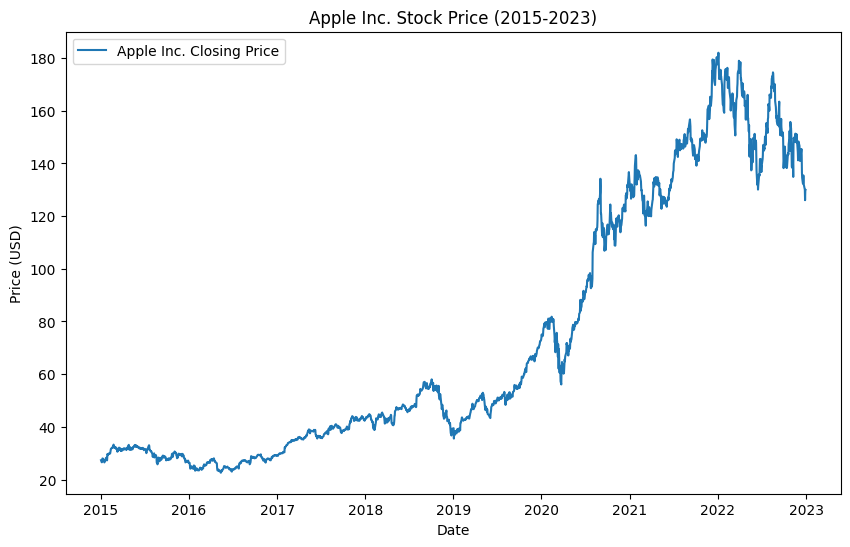

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch Apple Inc. stock data from Yahoo Finance
stock_data = yf.download('AAPL', start='2015-01-01', end='2023-01-01')

# Use the 'Close' price as the main time series
stock_data = stock_data[['Close']]

# Plot the stock prices
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'], label='Apple Inc. Closing Price')
plt.title('Apple Inc. Stock Price (2015-2023)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


# Step 2: Check for Stationarity


```Since stock prices often exhibit trends, we need to check whether the time series is stationary. If not, we will apply differencing to make it stationary.```

In [2]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("Series is non-stationary")
    else:
        print("Series is stationary")

# Apply stationarity check on the stock prices
check_stationarity(stock_data['Close'])


ADF Statistic: -0.6563133120479199
p-value: 0.8577432792361144
Series is non-stationary


```If the series is non-stationary, apply differencing:```

<ipython-input-3-991c32a33e19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Close_diff'] = stock_data['Close'].diff().dropna()


ADF Statistic: -9.262153073571673
p-value: 1.397721030726703e-15
Series is stationary


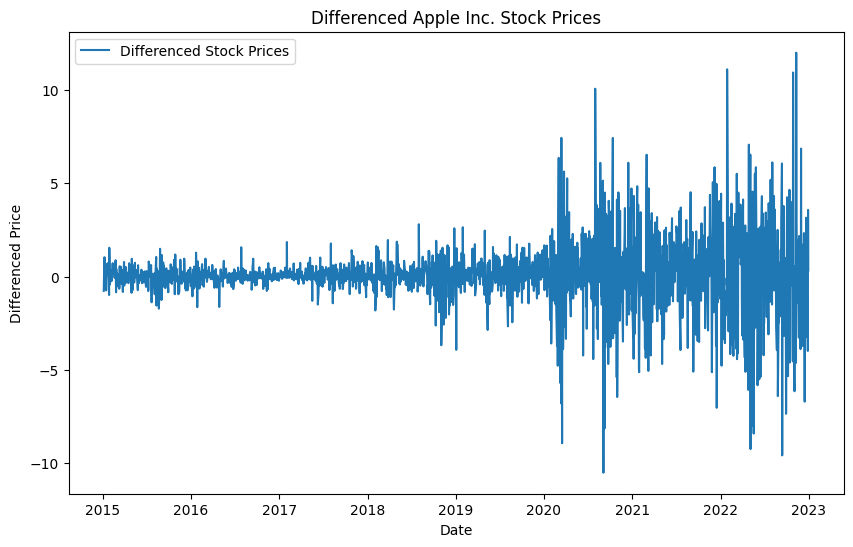

In [3]:
# First differencing to remove trend
stock_data['Close_diff'] = stock_data['Close'].diff().dropna()

# Check stationarity again on the differenced series
check_stationarity(stock_data['Close_diff'].dropna())

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close_diff'], label='Differenced Stock Prices')
plt.title('Differenced Apple Inc. Stock Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()


# Step 3: Determine AR Order Using PACF


```We'll now use the Partial Autocorrelation Function (PACF) to determine the optimal number of lags (AR order).```

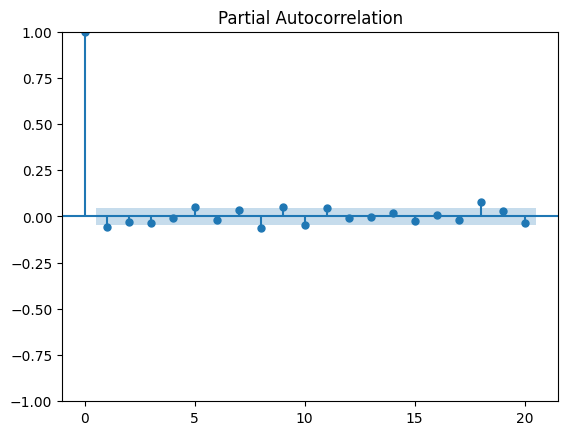

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF to determine order of the AR model
plot_pacf(stock_data['Close_diff'].dropna(), lags=20, method='ywm')
plt.show()


# Step 4: Fit the AR Model


  ```Let’s assume the PACF suggests an AR(2) model based on the plot. We can now fit the AR model to the differenced data.```

In [5]:
from statsmodels.tsa.ar_model import AutoReg

# Define the lag order (assuming PACF shows 2 lags)
p = 2

# Fit the AR model on the differenced series
model = AutoReg(stock_data['Close_diff'].dropna(), lags=p).fit()

# Print model summary
print(model.summary())


                            AutoReg Model Results                             
Dep. Variable:             Close_diff   No. Observations:                 2013
Model:                     AutoReg(2)   Log Likelihood               -4008.854
Method:               Conditional MLE   S.D. of innovations              1.776
Date:                Wed, 09 Oct 2024   AIC                           8025.708
Time:                        11:30:28   BIC                           8048.134
Sample:                             2   HQIC                          8033.940
                                 2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0558      0.040      1.408      0.159      -0.022       0.134
Close_diff.L1    -0.0579      0.022     -2.599      0.009      -0.102      -0.014
Close_diff.L2    -0.0298      0.022     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Step 5: Model Diagnostics


```It’s essential to check that the residuals behave like white noise. If the residuals show autocorrelation, the model may need refinement.```

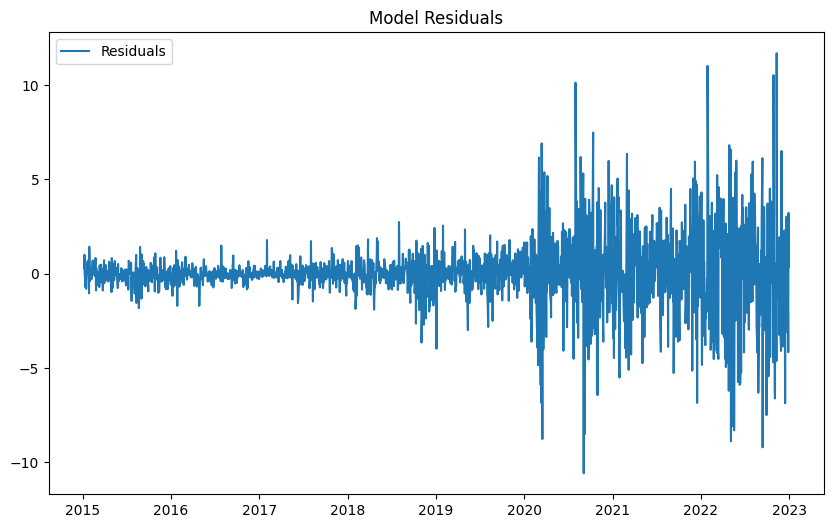

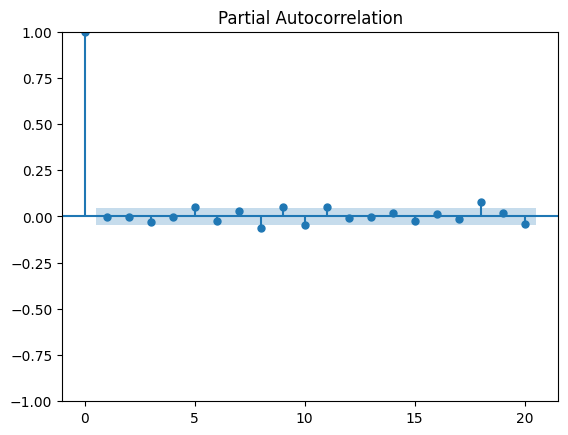

In [6]:
# Plot the residuals of the modelIt’s essential to check that the residuals behave like white noise. If the residuals show autocorrelation, the model may need refinement.
residuals = model.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('Model Residuals')
plt.legend()
plt.show()

# Plot PACF of residuals to check for remaining autocorrelation
plot_pacf(residuals, lags=20, method='ywm')
plt.show()


# Step 6: Forecast Future Stock Prices


```Now that the model is fitted, we can forecast the next 30 days of stock prices. We will need to invert the differencing step to get the forecast on the original scale.```

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


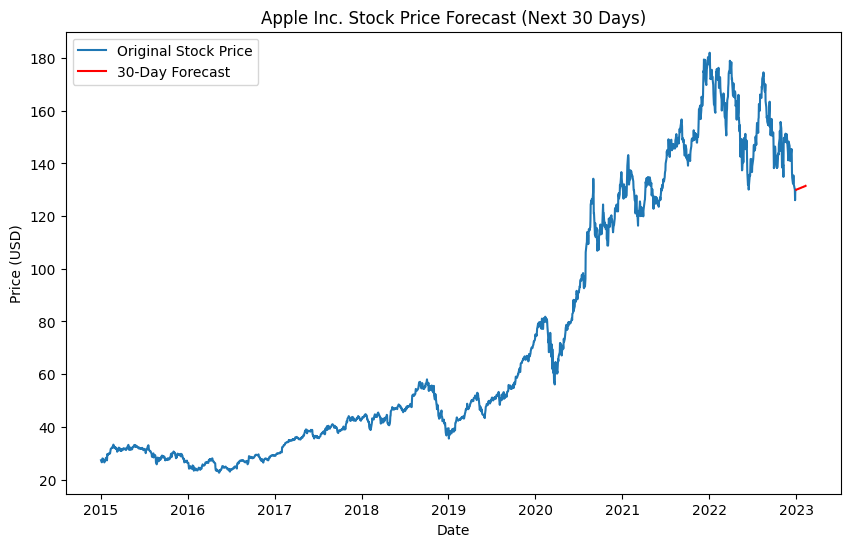

In [7]:
# Forecasting the next 30 days of differenced prices
forecast_diff = model.predict(start=len(stock_data['Close_diff']), end=len(stock_data['Close_diff']) + 30 - 1)

# Invert the differencing to get the forecast on the original scale
forecast = stock_data['Close'].iloc[-1] + forecast_diff.cumsum()

# Create a time index for the forecast
forecast_index = pd.date_range(stock_data.index[-1], periods=31, freq='B')[1:]  # Business days only

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'], label='Original Stock Price')
plt.plot(forecast_index, forecast, label='30-Day Forecast', color='red')
plt.title('Apple Inc. Stock Price Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


# Step 7: Model Evaluation (Optional)


```If you have a test dataset (historical data that wasn’t used for training), you can evaluate the accuracy of your model using RMSE or MAE. Here’s how to calculate RMSE:```

In [11]:
from sklearn.metrics import mean_squared_error

# Example: Assume you have test data for evaluation
test_data = []  # actual future stock prices for evaluation

# Forecast for the test period
forecast_test = model.predict(start=len(stock_data['Close_diff']) - len(test_data), end=len(stock_data['Close_diff']) - 1)

# Invert the differencing to compare on the original scale
forecast_test_inverted = stock_data['Close'].iloc[-len(test_data)-1] + forecast_test.cumsum()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast_test_inverted))
print(f'RMSE: {rmse}')


ValueError: Prediction must have `end` after `start`.

# Summary of the Project Pipeline


1. Data Collection: Fetch the stock price data from yfinance.

2. Check for Stationarity: Use the ADF test and apply differencing if necessary.

3. Determine AR Order: Use PACF to select the number of lags 𝑝

4. Fit the AR Model: Fit the AR(p) model to the differenced data.

5. Model Diagnostics: Ensure residuals show no autocorrelation.

6. Forecast Future Prices: Predict the next 30 days and plot the results.


7. Evaluate the Model: Optionally, use test data to evaluate model performance.

# Example: ML Pipeline for AR Model in Python


In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from joblib import dump, load
import matplotlib.pyplot as plt

# Step 1: Data Ingestion & Preparation
def load_data(X=None): # Modified: Added X parameter with default value None
    """Loads the data.

    Args:
        X: Input data (ignored in this case).

    Returns:
        pandas.Series: Stock close price.
    """
    # Replace with actual data source, e.g., from a file or API
    data = pd.read_csv('your_data.csv')
    return data['Close']  # Example: stock close price

# ... (rest of the code remains the same)
def check_stationarity(data):
    # Apply differencing if necessary (assuming p-value from ADF > 0.05)
    return data.diff().dropna()

# Step 2: Model Selection (order p can be decided based on PACF plot)
def select_order_p(data):
    # Here we assume the user already knows the best 'p'
    return 2  # Example p=2 (this can be automated with PACF analysis)

# Step 3: Model Fitting
def fit_model(data, p):
    model = AutoReg(data, lags=p).fit()
    return model

# Step 4: Forecasting
def forecast(model, steps=10):
    return model.predict(start=len(model.data.endog), end=len(model.data.endog) + steps - 1)

# Step 5: Model Evaluation
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)  # RMSE

# Step 6: Save/Load Model
def save_model(model, filename):
    dump(model, filename)

def load_model(filename):
    return load(filename)

# Define ML Pipeline
def create_ar_pipeline():
    pipeline = Pipeline([
        ('load_data', FunctionTransformer(func=load_data, validate=False)),
        ('stationarity_check', FunctionTransformer(func=check_stationarity, validate=False)),
        ('model_fitting', FunctionTransformer(func=lambda x: fit_model(x, select_order_p(x)), validate=False)),
    ])
    return pipeline

# Running the pipeline
pipeline = create_ar_pipeline()
data = pipeline.fit_transform(None)  # None, because pipeline handles data loading

# Forecasting
model = pipeline.named_steps['model_fitting']
predicted_values = forecast(model, steps=10)

# Optional: Save the model for future use
save_model(model, 'ar_model.joblib')

# Model evaluation (if you have test data for evaluation)
# Assuming `test_data` is available:
# rmse = evaluate_model(test_data, predicted_values)


FileNotFoundError: [Errno 2] No such file or directory: 'your_data.csv'